In [1]:
#test gpu enabled
import tensorflow as tf
# Get the GPU device name.
device_name = tf.test.gpu_device_name()
# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')


Found GPU at: /device:GPU:0


In [2]:
# If there's a GPU available...
import torch
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
# Installing transormets lib
!pip install transformers


     |████████████████████████████████| 1.3MB 4.5MB/s 
     |████████████████████████████████| 890kB 55.9MB/s 
     |████████████████████████████████| 2.9MB 49.8MB/s 
     |████████████████████████████████| 1.1MB 33.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=e8bae48e148cc5c530a65879e1b0a128cadb3b79c78b1335f6c0cd32c5964854
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
# Open files from Google Drive
# TODO change to git repo
from google.colab import drive
drive.mount('/content/drive')
source_folder = '/content/drive/My Drive/nlp/clinical-sts/data'
destination_folder = '/content/drive/My Drive/nlp/clinical-sts/classification-model'

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import os as os
df = pd.read_csv(os.path.join(source_folder,"augumented_train.txt"), delimiter='\t', header=None, names=['sentenceA', 'sentenceB', 'score', 'label'])
print('Number of training sentences: {:,}\n'.format(df.shape[0]*2))
# Get the lists of sentences and their labels.
sentences = np.concatenate((df.sentenceA.values , df.sentenceB.values)) # use both sentences
print("sentences",sentences.size)
raw_labels = np.concatenate((df.label.values,df.label.values)) # labels for both sentences
print("raw labels",raw_labels)
encoded_labels = []
for raw_label in raw_labels:
  encoded_labels.append(0) if raw_label=='CLINICAL' else encoded_labels.append(1)
print("encoded labels",encoded_labels)
labels = np.array(encoded_labels)
print("labels",labels)

'''
CLINICAL : 0
MEDICAL  : 1
'''
print("5 samples")
for i in range(0,5): #np.random.choice(sentences.shape[0], 5, replace=False):
  print(sentences[i],raw_labels[i],labels[i])
  


Number of training sentences: 3,308

sentences 3308
raw labels ['CLINICAL' 'MEDICAL' 'CLINICAL' ... 'CLINICAL' 'CLINICAL' 'CLINICAL']
encoded labels [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

In [6]:
#check labels match for sentences A and B
mismatch =0
for i in range(0,1654):
  if labels[i] != labels[i+1654]:
    mismatch+=1
print("labels mismatch",mismatch)
print(labels[1:20])


labels mismatch 0
[1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0]


In [7]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [8]:
# train val split
# test set is provided separately
from sklearn.model_selection import train_test_split
from dataclasses import dataclass

X_train, X_val, y_train, y_val = train_test_split(sentences, labels, stratify=labels, test_size=0.2, random_state=42)
data_split_dir = source_folder+'/split'
with open(os.path.join(data_split_dir,'train.tsv'),'w+') as wf:
  for txt, lbl in zip(X_train, y_train):
    wf.write(str(str(lbl)+'\t'+txt+'\n'))
with open(os.path.join(data_split_dir,'validation.tsv'),'w+') as wf:
  for txt, lbl in zip(X_val, y_val):
    wf.write(str(str(lbl)+'\t'+txt+'\n'))
print("split save to",data_split_dir)
print("Train samples",len(X_train),len(y_train))
print("Validation samples",len(X_val),len(y_val))


split save to /content/drive/My Drive/nlp/clinical-sts/data/split
Train samples 2646 2646
Validation samples 662 662


(array([541., 121.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

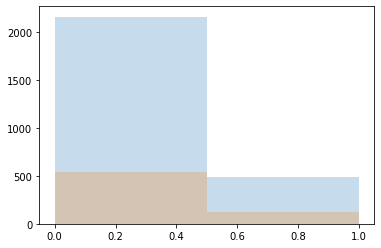

In [9]:
# validate stratified split
import matplotlib.pyplot as plt
plt.hist(y_train,bins=2, alpha=0.25)
plt.hist(y_val,bins=2, alpha=0.25)

In [10]:
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('text', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(data_split_dir, train='train.tsv', validation='validation.tsv',
                                           test='test.tsv', format='TSV', fields=fields, skip_header=False)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)
print("Created train/val/test Dataset from split")

Created train/val/test Dataset from split


In [11]:

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [12]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [19]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, text), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, text), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'seq_classification_model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [20]:
# load pretrained BERT model
print(device)
import torch.optim as optim
model = BERT().to(device)
print(type(model))
print(destination_folder)
save_checkpoint(destination_folder+'/'+'seq_classification_model.pt',model,'0.1')
optimizer = optim.Adam(model.parameters(), lr=2e-5)

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<class '__main__.BERT'>
/content/drive/My Drive/nlp/clinical-sts/classification-model
Model saved to ==> /content/drive/My Drive/nlp/clinical-sts/classification-model/seq_classification_model.pt


In [21]:
# Training
train(model=model, optimizer=optimizer)

#['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']

Epoch [1/5], Step [83/830], Train Loss: 0.3239, Valid Loss: 0.4080
Model saved to ==> /content/drive/My Drive/nlp/clinical-sts/classification-model/seq_classification_model.pt
Model saved to ==> /content/drive/My Drive/nlp/clinical-sts/classification-model/metrics.pt
Epoch [1/5], Step [166/830], Train Loss: 0.1058, Valid Loss: 0.0567
Model saved to ==> /content/drive/My Drive/nlp/clinical-sts/classification-model/seq_classification_model.pt
Model saved to ==> /content/drive/My Drive/nlp/clinical-sts/classification-model/metrics.pt
Epoch [2/5], Step [249/830], Train Loss: 0.0437, Valid Loss: 0.0812
Epoch [2/5], Step [332/830], Train Loss: 0.0591, Valid Loss: 0.0480
Model saved to ==> /content/drive/My Drive/nlp/clinical-sts/classification-model/seq_classification_model.pt
Model saved to ==> /content/drive/My Drive/nlp/clinical-sts/classification-model/metrics.pt
Epoch [3/5], Step [415/830], Train Loss: 0.0382, Valid Loss: 0.0413
Model saved to ==> /content/drive/My Drive/nlp/clinical-st

Model loaded from <== /content/drive/My Drive/nlp/clinical-sts/classification-model/metrics.pt


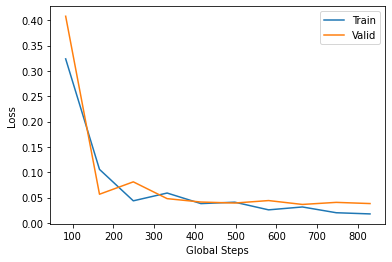

In [22]:
# training losses
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [25]:
# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, text), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['MEDICAL', 'CLINICAL'])
    ax.yaxis.set_ticklabels(['MEDICAL', 'CLINICAL'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/My Drive/nlp/clinical-sts/classification-model/seq_classification_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    0.9964    0.9982       280
           0     0.9982    1.0000    0.9991       544

    accuracy                         0.9988       824
   macro avg     0.9991    0.9982    0.9986       824
weighted avg     0.9988    0.9988    0.9988       824



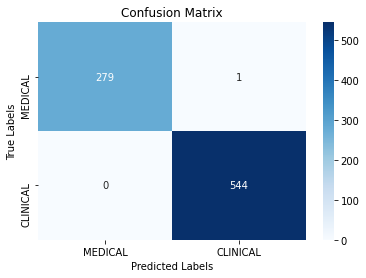

In [26]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/seq_classification_model.pt', best_model)

evaluate(best_model, test_iter)